In [2]:
## SETUP ##

import os
import numpy as np
import pandas as pd
import datetime
import time
import math
import random
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

In [3]:
### --------------- HELPER FUNCTIONS FOR DATA SIMULATION --------------- ###

In [4]:
## CUSTOMER PROFILE GENERATION ##
def generate_customer_profiles_table(n_customers, random_state=0):
    
    np.random.seed(random_state)
        
    customer_id_properties=[]
    
    # Generate customer properties from random distributions 
    for customer_id in range(n_customers):
        
        x_customer_id = np.random.uniform(0,100)
        y_customer_id = np.random.uniform(0,100)
        
        mean_amount = np.random.uniform(5,100) # Arbitrary (but sensible) value 
        std_amount = mean_amount/2 # Arbitrary (but sensible) value
        
        mean_nb_tx_per_day = np.random.uniform(0,4) # Arbitrary (but sensible) value 
        
        customer_id_properties.append([customer_id,
                                      x_customer_id, y_customer_id,
                                      mean_amount, std_amount,
                                      mean_nb_tx_per_day])
        
    customer_profiles_table = pd.DataFrame(customer_id_properties, columns=['CUSTOMER_ID',
                                                                      'x_customer_id', 'y_customer_id',
                                                                      'mean_amount', 'std_amount',
                                                                      'mean_nb_tx_per_day'])
    
    return customer_profiles_table

In [5]:
## TERMINAL PROFILES GENERATION ##
def generate_terminal_profiles_table(n_terminals, random_state=0):
    
    np.random.seed(random_state)
        
    terminal_id_properties=[]
    
    # Generate terminal properties from random distributions 
    for terminal_id in range(n_terminals):
        
        x_terminal_id = np.random.uniform(0,100)
        y_terminal_id = np.random.uniform(0,100)
        
        terminal_id_properties.append([terminal_id,
                                      x_terminal_id, y_terminal_id])
                                       
    terminal_profiles_table = pd.DataFrame(terminal_id_properties, columns=['TERMINAL_ID',
                                                                      'x_terminal_id', 'y_terminal_id'])
    
    return terminal_profiles_table

In [6]:
## TERMINALS WITHIN RADIUS ##
def get_list_terminals_within_radius(customer_profile, x_y_terminals, r):
    
    # Use numpy arrays in the following to speed up computations
    
    # Location (x,y) of customer as numpy array
    x_y_customer = customer_profile[['x_customer_id','y_customer_id']].values.astype(float)
    
    # Squared difference in coordinates between customer and terminal locations
    squared_diff_x_y = np.square(x_y_customer - x_y_terminals)
    
    # Sum along rows and compute suared root to get distance
    dist_x_y = np.sqrt(np.sum(squared_diff_x_y, axis=1))
    
    # Get the indices of terminals which are at a distance less than r
    available_terminals = list(np.where(dist_x_y<r)[0])
    
    # Return the list of terminal IDs
    return available_terminals
    

In [7]:
## GENERATE TRANSACTIONS ##
def generate_transactions_table(customer_profile, start_date = "2018-04-01", nb_days = 10):
    
    customer_transactions = []
    
    random.seed(int(customer_profile.CUSTOMER_ID))
    np.random.seed(int(customer_profile.CUSTOMER_ID))
    
    # For all days
    for day in range(nb_days):
        
        # Random number of transactions for that day 
        nb_tx = np.random.poisson(customer_profile.mean_nb_tx_per_day)
        
        # If nb_tx positive, let us generate transactions
        if nb_tx>0:
            
            for tx in range(nb_tx):
                
                # Time of transaction: Around noon, std 20000 seconds. This choice aims at simulating the fact that 
                # most transactions occur during the day.
                time_tx = int(np.random.normal(86400/2, 20000))
                
                # If transaction time between 0 and 86400, let us keep it, otherwise, let us discard it
                if (time_tx>0) and (time_tx<86400):
                    
                    # Amount is drawn from a normal distribution  
                    amount = np.random.normal(customer_profile.mean_amount, customer_profile.std_amount)
                    
                    # If amount negative, draw from a uniform distribution
                    if amount<0:
                        amount = np.random.uniform(0,customer_profile.mean_amount*2)
                    
                    amount=np.round(amount,decimals=2)
                    
                    if len(customer_profile.available_terminals)>0:
                        
                        terminal_id = random.choice(customer_profile.available_terminals)
                    
                        customer_transactions.append([time_tx+day*86400, day,
                                                      customer_profile.CUSTOMER_ID, 
                                                      terminal_id, amount])
            
    customer_transactions = pd.DataFrame(customer_transactions, columns=['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT'])
    
    if len(customer_transactions)>0:
        customer_transactions['TX_DATETIME'] = pd.to_datetime(customer_transactions["TX_TIME_SECONDS"], unit='s', origin=start_date)
        customer_transactions=customer_transactions[['TX_DATETIME','CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']]
    
    return customer_transactions  
    
    

In [8]:
## GENERATE LARGE DATASET ##
def generate_dataset(n_customers = 10000, n_terminals = 1000000, nb_days=90, start_date="2018-04-01", r=5):
    
    start_time=time.time()
    customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = 0)
    print("Time to generate customer profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    terminal_profiles_table = generate_terminal_profiles_table(n_terminals, random_state = 1)
    print("Time to generate terminal profiles table: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)
    customer_profiles_table['available_terminals'] = customer_profiles_table.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    # With Pandarallel
    #customer_profiles_table['available_terminals'] = customer_profiles_table.parallel_apply(lambda x : get_list_closest_terminals(x, x_y_terminals=x_y_terminals, r=r), axis=1)
    customer_profiles_table['nb_terminals']=customer_profiles_table.available_terminals.apply(len)
    print("Time to associate terminals to customers: {0:.2}s".format(time.time()-start_time))
    
    start_time=time.time()
    transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days, start_date=start_date)).reset_index(drop=True)
    # With Pandarallel
    #transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').parallel_apply(lambda x : generate_transactions_table(x.iloc[0], nb_days=nb_days)).reset_index(drop=True)
    print("Time to generate transactions: {0:.2}s".format(time.time()-start_time))
    
    # Sort transactions chronologically
    transactions_df=transactions_df.sort_values('TX_DATETIME')
    # Reset indices, starting from 0
    transactions_df.reset_index(inplace=True,drop=True)
    transactions_df.reset_index(inplace=True)
    # TRANSACTION_ID are the dataframe indices, starting from 0
    transactions_df.rename(columns = {'index':'TRANSACTION_ID'}, inplace = True)
    
    return (customer_profiles_table, terminal_profiles_table, transactions_df)
    

In [9]:
## GENERATE FRAUDULENT TRANSACTIONS ##
def add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df, fraud_tx_amount=220, nb_compromised_terminals_daily=2, nb_compromised_customers_daily=3, my_seed=771):
    
    # By default, all transactions are genuine
    transactions_df['TX_FRAUD']=0
    transactions_df['TX_FRAUD_SCENARIO']=0
    
    
    # Scenario 1
    if fraud_tx_amount != -1:
        transactions_df.loc[transactions_df.TX_AMOUNT>fraud_tx_amount, 'TX_FRAUD']=1
        transactions_df.loc[transactions_df.TX_AMOUNT>fraud_tx_amount, 'TX_FRAUD_SCENARIO']=1
        nb_frauds_scenario_1 = transactions_df.TX_FRAUD.sum()
    else:
        nb_frauds_scenario_1 = 0
    print("Number of frauds from scenario 1: "+str(nb_frauds_scenario_1))
    
    
    # Scenario 2
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        
        random.seed(day)
        compromised_terminals = terminal_profiles_table.TERMINAL_ID.sample(n=nb_compromised_terminals_daily, random_state=day)
        
        compromised_transactions = transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                    (transactions_df.TX_TIME_DAYS<day+28) & 
                                                    (transactions_df.TERMINAL_ID.isin(compromised_terminals))]
                            
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD']=1
        transactions_df.loc[compromised_transactions.index,'TX_FRAUD_SCENARIO']=2
    
    nb_frauds_scenario_2=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_1
    print("Number of frauds from scenario 2: "+str(nb_frauds_scenario_2))
    
    
    # Scenario 3
    for day in range(transactions_df.TX_TIME_DAYS.max()):
        
        compromised_customers = customer_profiles_table.CUSTOMER_ID.sample(n=nb_compromised_customers_daily, random_state=day).values
        
        compromised_transactions = transactions_df[(transactions_df.TX_TIME_DAYS>=day) & 
                                                    (transactions_df.TX_TIME_DAYS<day+14) & 
                                                    (transactions_df.CUSTOMER_ID.isin(compromised_customers))]
        
        nb_compromised_transactions = len(compromised_transactions)
        
        random.seed(day)
        index_fauds = random.sample(list(compromised_transactions.index.values),k=int(nb_compromised_transactions/3))
        
        transactions_df.loc[index_fauds,'TX_AMOUNT']=transactions_df.loc[index_fauds,'TX_AMOUNT']*5
        transactions_df.loc[index_fauds,'TX_FRAUD']=1
        transactions_df.loc[index_fauds,'TX_FRAUD_SCENARIO']=3
    
    nb_frauds_scenario_3=transactions_df.TX_FRAUD.sum()-nb_frauds_scenario_2-nb_frauds_scenario_1
    print("Number of frauds from scenario 3: "+str(nb_frauds_scenario_3))
    
    
    # Print value of parameters
    print("Fraud transaction amount for scenario 1: "+str(fraud_tx_amount))
    print("Number of compromised terminals per day for scenario 2: "+str(nb_compromised_terminals_daily))
    print("Number of compromised customers per day for scenario 3: "+str(nb_compromised_customers_daily))
    
    # Print some stats on final results
    print("Mean number of fraud transactions: "+str(transactions_df.TX_FRAUD.mean()))
    
    return transactions_df                 

In [10]:
## DATA TRANSFORMATION - WEEKEND INDICATOR ##
def is_weekend(tx_datetime):
    
    # Transform date into weekday (0 is Monday, 6 is Sunday)
    weekday = tx_datetime.weekday()
    # Binary value: 0 if weekday, 1 if weekend
    is_weekend = weekday>=5
    
    return int(is_weekend)

In [11]:
## DATA TRANSFORMATION - NIGHT INDICATOR ##
def is_night(tx_datetime):
    
    # Get the hour of the transaction
    tx_hour = tx_datetime.hour
    # Binary value: 1 if hour less than 6, and 0 otherwise
    is_night = tx_hour<=6
    
    return int(is_night)

In [12]:
## DATA TRANSFORMATION - CUSTOMER SPENDING AGGREGATION ##
def get_customer_spending_behaviour_features(customer_transactions, windows_size_in_days=[1,7,30]):
    
    # Let us first order transactions chronologically
    customer_transactions=customer_transactions.sort_values('TX_DATETIME')
    
    # The transaction date and time is set as the index, which will allow the use of the rolling function 
    customer_transactions.index=customer_transactions.TX_DATETIME
    
    # For each window size
    for window_size in windows_size_in_days:
        
        # Compute the sum of the transaction amounts and the number of transactions for the given window size
        SUM_AMOUNT_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').sum()
        NB_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').count()
    
        # Compute the average transaction amount for the given window size
        # NB_TX_WINDOW is always >0 since current transaction is always included
        AVG_AMOUNT_TX_WINDOW=SUM_AMOUNT_TX_WINDOW/NB_TX_WINDOW
    
        # Save feature values
        customer_transactions['CUSTOMER_ID_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        customer_transactions['CUSTOMER_ID_AVG_AMOUNT_'+str(window_size)+'DAY_WINDOW']=list(AVG_AMOUNT_TX_WINDOW)
    
    # Reindex according to transaction IDs
    customer_transactions.index=customer_transactions.TRANSACTION_ID
        
    # And return the dataframe with the new features
    return customer_transactions

In [13]:
## DATA TRANSFORMATION - TERMINAL RISK SCORE ##
def get_count_risk_rolling_window(terminal_transactions, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"):
    
    terminal_transactions=terminal_transactions.sort_values('TX_DATETIME')
    
    terminal_transactions.index=terminal_transactions.TX_DATETIME
    
    NB_FRAUD_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').sum()
    NB_TX_DELAY=terminal_transactions['TX_FRAUD'].rolling(str(delay_period)+'d').count()
    
    for window_size in windows_size_in_days:
    
        NB_FRAUD_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').sum()
        NB_TX_DELAY_WINDOW=terminal_transactions['TX_FRAUD'].rolling(str(delay_period+window_size)+'d').count()
    
        NB_FRAUD_WINDOW=NB_FRAUD_DELAY_WINDOW-NB_FRAUD_DELAY
        NB_TX_WINDOW=NB_TX_DELAY_WINDOW-NB_TX_DELAY
    
        RISK_WINDOW=NB_FRAUD_WINDOW/NB_TX_WINDOW
        
        terminal_transactions[feature+'_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        terminal_transactions[feature+'_RISK_'+str(window_size)+'DAY_WINDOW']=list(RISK_WINDOW)
        
    terminal_transactions.index=terminal_transactions.TRANSACTION_ID
    
    # Replace NA values with 0 (all undefined risk scores where NB_TX_WINDOW is 0) 
    terminal_transactions.fillna(0,inplace=True)
    
    return terminal_transactions

In [14]:
## PERFORM ALL DATA TRANSFORMATIONS ##
def apply_all_trans(transactions_df):
    
    new_transactions_df = transactions_df.copy(deep=True)
    
    # Create a new variable indicating if the transaction was made during the weekend
    %time new_transactions_df['TX_DURING_WEEKEND']=new_transactions_df.TX_DATETIME.apply(is_weekend)

    # Create a new variable indicating if the transaction was made during the night
    %time new_transactions_df['TX_DURING_NIGHT']=new_transactions_df.TX_DATETIME.apply(is_night)
    
    # Create 6 new variables on customer spending:
    # -> Number of transactions over 1, 7, and 30 days
    # -> Average amount spent in these transactions over 1, 7, and 30 days
    %time new_transactions_df=new_transactions_df.groupby('CUSTOMER_ID').apply(lambda x: get_customer_spending_behaviour_features(x, windows_size_in_days=[1,7,30]))
    new_transactions_df=new_transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)

    # Create 3 variables on terminal risk:
    # -> Avg number of fraud transactions from a terminal ID (i.e. risk score) over 1, 7, and 30 days 
    %time new_transactions_df=new_transactions_df.groupby('TERMINAL_ID').apply(lambda x: get_count_risk_rolling_window(x, delay_period=7, windows_size_in_days=[1,7,30], feature="TERMINAL_ID"))
    new_transactions_df=new_transactions_df.sort_values('TX_DATETIME').reset_index(drop=True)
    
    # Convert date timestamp to integer values
    if 'TX_DATETIME' in new_transactions_df.columns:
        new_transactions_df['TX_DATETIME'] = new_transactions_df['TX_DATETIME'].astype(int)
    
    # Remove transcaction ID since it's just the row number
    if 'TRANSACTION_ID' in new_transactions_df.columns:
        new_transactions_df.drop('TRANSACTION_ID', axis=1)
    
    return new_transactions_df

In [15]:
## GENERATE NOISE PREDICTORS ##
def add_noise(transactions_df, nb_noise_predictors, seed_state=771):
    
    new_transactions_df = transactions_df
    
    # Add the given number of noise predictors
    for i in range(0,nb_noise_predictors):
        col_name = 'NOISE_' + str(i)
        random.seed(seed_state+i)
        new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
    
    return new_transactions_df

In [16]:
## SELECT SIGNAL PREDICTORS ##
def select_signals(transactions_df, nb_signal_predictors, response_var='TX_FRAUD', seed_state=771):
    
    new_transactions_df = transactions_df
    
    response_var_i = new_transactions_df.columns.get_loc(response_var)
    available_vars_i = list(range(0,new_transactions_df.shape[1]))
    available_vars_i = [x for x in available_vars_i if x not in [response_var_i]]
    vars_to_keep_i = [response_var_i]
    
    
    # Randomly select the given number of signal predictors, assuming all are signals
    for i in range(0,nb_signal_predictors):
        random.seed(seed_state+i)
        selected_i = available_vars_i[random.randint(0, len(available_vars_i)-1)]
        available_vars_i = [x for x in available_vars_i if x not in [selected_i]]
        vars_to_keep_i = vars_to_keep_i + [selected_i]

    new_transactions_df = new_transactions_df.iloc[:, vars_to_keep_i]
    
    return new_transactions_df

In [17]:
### --------------- SIMULATED DATASETS --------------- ###

In [18]:
## --- BASE TRANSACTIONS SETUP --- ##

In [19]:
# Generate transactions
(customer_profiles_table, terminal_profiles_table, transactions_df)=\
    generate_dataset(n_customers = 5000, 
                     n_terminals = 10000, 
                     nb_days=365, 
                     start_date="2018-04-01", 
                     r=5)

Time to generate customer profiles table: 0.057s
Time to generate terminal profiles table: 0.058s
Time to associate terminals to customers: 2.5s
Time to generate transactions: 2.1e+02s


In [20]:
customer_profiles_table.head(10)

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,available_terminals,nb_terminals
0,0,54.881350,71.518937,62.262521,31.131260,2.179533,"[29, 87, 144, 241, 330, 858, 996, 1028, 1067, ...",78
1,1,42.365480,64.589411,46.570785,23.285393,3.567092,"[5, 160, 242, 378, 431, 475, 571, 762, 876, 93...",85
2,2,96.366276,38.344152,80.213879,40.106939,2.115580,"[316, 406, 447, 523, 968, 1200, 1318, 1365, 16...",70
3,3,56.804456,92.559664,11.748426,5.874213,0.348517,"[65, 94, 113, 364, 401, 433, 485, 651, 672, 77...",70
4,4,2.021840,83.261985,78.924891,39.462446,3.480049,"[372, 614, 774, 1362, 1446, 1564, 1637, 1939, ...",65
5,5,97.861834,79.915856,48.840539,24.420270,3.122117,"[79, 200, 266, 480, 568, 741, 1392, 1469, 1486...",61
6,6,11.827443,63.992102,18.618562,9.309281,3.778676,"[163, 172, 205, 429, 468, 607, 750, 786, 881, ...",67
7,7,52.184832,41.466194,30.132783,15.066392,3.096935,"[563, 612, 700, 705, 859, 1036, 1231, 1442, 14...",78
8,8,45.615033,56.843395,6.785031,3.392516,2.470542,"[8, 46, 115, 117, 190, 431, 648, 891, 937, 958...",95
9,9,61.209572,61.693400,94.656067,47.328034,2.727281,"[84, 128, 314, 415, 547, 797, 809, 824, 983, 1...",92


In [21]:
customer_profiles_table.shape

(5000, 8)

In [22]:
terminal_profiles_table.head(10)

,TERMINAL_ID,x_terminal_id,y_terminal_id
0,0,41.702200,72.032449
1,1,0.011437,30.233257
2,2,14.675589,9.233859
3,3,18.626021,34.556073
4,4,39.676747,53.881673
5,5,41.919451,68.521950
6,6,20.445225,87.811744
7,7,2.738759,67.046751
8,8,41.730480,55.868983
9,9,14.038694,19.810149


In [23]:
terminal_profiles_table.shape

(10000, 3)

In [24]:
transactions_df.head(10)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0
5,5,2018-04-01 00:10:45,568,8803,44.71,645,0
6,6,2018-04-01 00:11:30,2803,5490,96.03,690,0
7,7,2018-04-01 00:11:44,4684,2486,24.36,704,0
8,8,2018-04-01 00:11:53,4128,8354,26.34,713,0
9,9,2018-04-01 00:13:44,541,6212,59.07,824,0


In [25]:
transactions_df.shape

(3500393, 7)

In [26]:
%%capture

distribution_amount_times_fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_AMOUNT'].sample(n=10000).values
time_val = transactions_df[transactions_df.TX_TIME_DAYS<10]['TX_TIME_SECONDS'].sample(n=10000).values

sns.distplot(amount_val, ax=ax[0], color='r', hist = True, kde = False)
ax[0].set_title('Distribution of transaction amounts', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])
ax[0].set(xlabel = "Amount", ylabel="Number of transactions")

# We divide the time variables by 86400 to transform seconds to days in the plot
sns.distplot(time_val/86400, ax=ax[1], color='b', bins = 100, hist = True, kde = False)
ax[1].set_title('Distribution of transaction times', fontsize=14)
ax[1].set_xlim([min(time_val/86400), max(time_val/86400)])
ax[1].set_xticks(range(10))
ax[1].set(xlabel = "Time (days)", ylabel="Number of transactions")

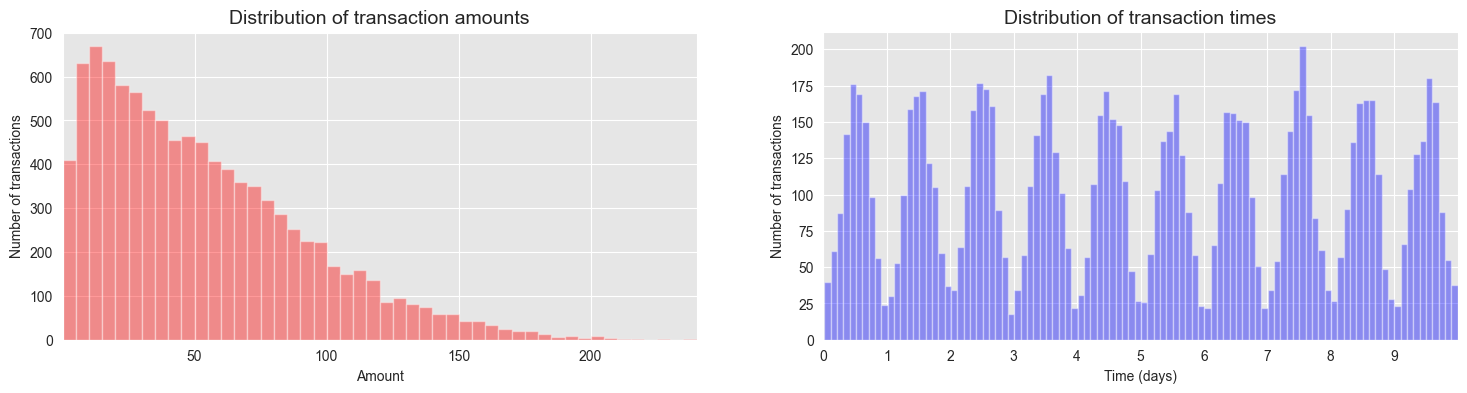

In [27]:
distribution_amount_times_fig

In [28]:
## --- UNBALANCED CLASSES (UNC) DATASETS --- ##

In [29]:
# Simulate data where 0.35% of the transactions are fraud
%time transactions_df_unc1 = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df, fraud_tx_amount=-1, nb_compromised_terminals_daily=1, nb_compromised_customers_daily=1)

Number of frauds from scenario 1: 0
Number of frauds from scenario 2: 9424
Number of frauds from scenario 3: 2924
Fraud transaction amount for scenario 1: -1
Number of compromised terminals per day for scenario 2: 1
Number of compromised customers per day for scenario 3: 1
Mean number of fraud transactions: 0.003527603900476318
CPU times: user 5min 46s, sys: 2.45 s, total: 5min 48s
Wall time: 6min 1s


In [30]:
# Simulate data where 0.50% of the transactions are fraud
%time transactions_df_unc2 = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df, fraud_tx_amount=-1, nb_compromised_terminals_daily=1, nb_compromised_customers_daily=3)

Number of frauds from scenario 1: 0
Number of frauds from scenario 2: 9424
Number of frauds from scenario 3: 9391
Fraud transaction amount for scenario 1: -1
Number of compromised terminals per day for scenario 2: 1
Number of compromised customers per day for scenario 3: 3
Mean number of fraud transactions: 0.005375110737565753
CPU times: user 6min 26s, sys: 2.43 s, total: 6min 28s
Wall time: 6min 36s


In [31]:
# Simulate data where 0.80% of the transactions are fraud
%time transactions_df_unc3 = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df, fraud_tx_amount=-1, nb_compromised_terminals_daily=2, nb_compromised_customers_daily=3)

Number of frauds from scenario 1: 0
Number of frauds from scenario 2: 18868
Number of frauds from scenario 3: 9368
Fraud transaction amount for scenario 1: -1
Number of compromised terminals per day for scenario 2: 2
Number of compromised customers per day for scenario 3: 3
Mean number of fraud transactions: 0.008066522816152357
CPU times: user 6min 43s, sys: 2.22 s, total: 6min 46s
Wall time: 6min 55s


In [32]:
# Simulate data where 1.00% of the transactions are fraud
%time transactions_df_unc4 = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df, fraud_tx_amount=-1, nb_compromised_terminals_daily=3, nb_compromised_customers_daily=3)

Number of frauds from scenario 1: 0
Number of frauds from scenario 2: 28325
Number of frauds from scenario 3: 9338
Fraud transaction amount for scenario 1: -1
Number of compromised terminals per day for scenario 2: 3
Number of compromised customers per day for scenario 3: 3
Mean number of fraud transactions: 0.010759648987985064
CPU times: user 7min 9s, sys: 2.33 s, total: 7min 12s
Wall time: 7min 19s


In [33]:
# Simulate data where 1.50% of the transactions are fraud
%time transactions_df_unc5 = add_frauds(customer_profiles_table, terminal_profiles_table, transactions_df, fraud_tx_amount=-1, nb_compromised_terminals_daily=5, nb_compromised_customers_daily=3)

Number of frauds from scenario 1: 0
Number of frauds from scenario 2: 46620
Number of frauds from scenario 3: 9287
Fraud transaction amount for scenario 1: -1
Number of compromised terminals per day for scenario 2: 5
Number of compromised customers per day for scenario 3: 3
Mean number of fraud transactions: 0.015971635184963518
CPU times: user 7min 6s, sys: 2.7 s, total: 7min 9s
Wall time: 7min 24s


In [34]:
## --- DATA TRANSFORMATION --- ##

In [35]:
transactions_df_unc1 = apply_all_trans(transactions_df_unc1)

CPU times: user 6.49 s, sys: 265 ms, total: 6.76 s
Wall time: 7.06 s
CPU times: user 5.62 s, sys: 200 ms, total: 5.82 s
Wall time: 5.92 s
CPU times: user 32.1 s, sys: 1.17 s, total: 33.3 s
Wall time: 34.6 s
CPU times: user 1min 10s, sys: 1.27 s, total: 1min 12s
Wall time: 1min 14s


In [36]:
transactions_df_unc2 = apply_all_trans(transactions_df_unc2)

CPU times: user 6.52 s, sys: 226 ms, total: 6.75 s
Wall time: 7.17 s
CPU times: user 5.73 s, sys: 208 ms, total: 5.94 s
Wall time: 6.09 s
CPU times: user 32.1 s, sys: 1.05 s, total: 33.1 s
Wall time: 34.3 s
CPU times: user 1min 11s, sys: 1.3 s, total: 1min 13s
Wall time: 1min 16s


In [37]:
transactions_df_unc3 = apply_all_trans(transactions_df_unc3)

CPU times: user 6.19 s, sys: 195 ms, total: 6.38 s
Wall time: 6.52 s
CPU times: user 5.9 s, sys: 186 ms, total: 6.09 s
Wall time: 6.24 s
CPU times: user 32 s, sys: 1.12 s, total: 33.1 s
Wall time: 34.7 s
CPU times: user 1min 11s, sys: 1.28 s, total: 1min 12s
Wall time: 1min 15s


In [38]:
transactions_df_unc4 = apply_all_trans(transactions_df_unc4)

CPU times: user 6.84 s, sys: 219 ms, total: 7.06 s
Wall time: 7.14 s
CPU times: user 5.76 s, sys: 185 ms, total: 5.94 s
Wall time: 5.97 s
CPU times: user 30.5 s, sys: 968 ms, total: 31.5 s
Wall time: 31.6 s
CPU times: user 1min 10s, sys: 1.12 s, total: 1min 11s
Wall time: 1min 11s


In [39]:
transactions_df_unc5 = apply_all_trans(transactions_df_unc5)

CPU times: user 6.47 s, sys: 178 ms, total: 6.65 s
Wall time: 6.66 s
CPU times: user 5.26 s, sys: 167 ms, total: 5.42 s
Wall time: 5.43 s
CPU times: user 29.6 s, sys: 916 ms, total: 30.5 s
Wall time: 30.6 s
CPU times: user 1min 8s, sys: 953 ms, total: 1min 9s
Wall time: 1min 9s


In [40]:
## --- SIGNAL-TO-NOISE (SNR) DATASETS --- ##

In [41]:
# Simulate data where the ratio of signal predictors to noise predictors is 1:9, fraud tx is 0.8%
transactions_df_snr1 = select_signals(transactions_df_unc3, 1)
transactions_df_snr1 = add_noise(transactions_df_snr1, 9)

/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v

In [42]:
# Simulate data where the ratio of signal predictors to noise predictors is 3:7, fraud tx is 0.8%
transactions_df_snr2 = select_signals(transactions_df_unc3, 3)
transactions_df_snr2 = add_noise(transactions_df_snr2, 7)

/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v

In [43]:
# Simulate data where the ratio of signal predictors to noise predictors is 5:5, fraud tx is 0.8%
transactions_df_snr3 = select_signals(transactions_df_unc3, 5)
transactions_df_snr3 = add_noise(transactions_df_snr3, 5)

/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v

In [44]:
# Simulate data where the ratio of signal predictors to noise predictors is 7:3, fraud tx is 0.8%
transactions_df_snr4 = select_signals(transactions_df_unc3, 7)
transactions_df_snr4 = add_noise(transactions_df_snr4, 3)

/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])


In [45]:
# Simulate data where the ratio of signal predictors to noise predictors is 9:1, fraud tx is 0.8%
transactions_df_snr5 = select_signals(transactions_df_unc3, 9)
transactions_df_snr5 = add_noise(transactions_df_snr5, 1)

In [46]:
# Simulate data where the ratio of signal predictors to noise predictors is 1:9, fraud tx is 1%
transactions_df_snr6 = select_signals(transactions_df_unc4, 1)
transactions_df_snr6 = add_noise(transactions_df_snr6, 9)

/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v

In [47]:
# Simulate data where the ratio of signal predictors to noise predictors is 3:7, fraud tx is 1%
transactions_df_snr7 = select_signals(transactions_df_unc4, 3)
transactions_df_snr7 = add_noise(transactions_df_snr7, 7)

/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v

In [48]:
# Simulate data where the ratio of signal predictors to noise predictors is 5:5, fraud tx is 1%
transactions_df_snr8 = select_signals(transactions_df_unc4, 5)
transactions_df_snr8 = add_noise(transactions_df_snr8, 5)

/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v

In [49]:
# Simulate data where the ratio of signal predictors to noise predictors is 7:3, fraud tx is 1%
transactions_df_snr9 = select_signals(transactions_df_unc4, 7)
transactions_df_snr9 = add_noise(transactions_df_snr9, 3)

/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])


In [50]:
# Simulate data where the ratio of signal predictors to noise predictors is 9:1, fraud tx is 1%
transactions_df_snr10 = select_signals(transactions_df_unc1, 9)
transactions_df_snr10 = add_noise(transactions_df_snr10, 1)

In [77]:
# Simulate data where the ratio of signal predictors to noise predictors is 1:9, fraud tx is 0.35%
transactions_df_snr11 = select_signals(transactions_df_unc1, 1)
transactions_df_snr11 = add_noise(transactions_df_snr11, 9)

/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v

In [78]:
# Simulate data where the ratio of signal predictors to noise predictors is 2:8, fraud tx is 0.35%
transactions_df_snr12 = select_signals(transactions_df_unc1, 2)
transactions_df_snr12 = add_noise(transactions_df_snr12, 8)

/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v

In [79]:
# Simulate data where the ratio of signal predictors to noise predictors is 3:7, fraud tx is 0.35%
transactions_df_snr13 = select_signals(transactions_df_unc1, 3)
transactions_df_snr13 = add_noise(transactions_df_snr13, 7)

/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v

In [80]:
# Simulate data where the ratio of signal predictors to noise predictors is 4:6, fraud tx is 0.35%
transactions_df_snr14 = select_signals(transactions_df_unc1, 4)
transactions_df_snr14 = add_noise(transactions_df_snr14, 6)

/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v

In [81]:
# Simulate data where the ratio of signal predictors to noise predictors is 5:5, fraud tx is 0.35%
transactions_df_snr15 = select_signals(transactions_df_unc1, 5)
transactions_df_snr15 = add_noise(transactions_df_snr15, 5)

/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v

In [82]:
# Simulate data where the ratio of signal predictors to noise predictors is 6:4, fraud tx is 0.35%
transactions_df_snr16 = select_signals(transactions_df_unc1, 6)
transactions_df_snr16 = add_noise(transactions_df_snr16, 4)

/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v

In [83]:
# Simulate data where the ratio of signal predictors to noise predictors is 1:9, fraud tx is 1.50%
transactions_df_snr17 = select_signals(transactions_df_unc5, 1)
transactions_df_snr17 = add_noise(transactions_df_snr17, 9)

/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v

In [84]:
# Simulate data where the ratio of signal predictors to noise predictors is 5:5, fraud tx is 1.50%
transactions_df_snr18 = select_signals(transactions_df_unc5, 5)
transactions_df_snr18 = add_noise(transactions_df_snr18, 5)

/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/2271255093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_transactions_df.loc[:, col_name] = np.random.randint(low=1, high=100, size=new_transactions_df.shape[0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v

In [85]:
# Simulate data where the ratio of signal predictors to noise predictors is 9:1, fraud tx is 1.50%
transactions_df_snr19 = select_signals(transactions_df_unc5, 9)
transactions_df_snr19 = add_noise(transactions_df_snr19, 1)

In [56]:
### --------------- HELPER FUNCTIONS FOR KCV-SMOTE & KFS METHOD --------------- ###

In [57]:
## KCV-SMOTE ##

def kcv_smote(df, k):
    
    new_df = df
    
    # --- STEP A: Divide the training set into k parts --- #
    nb_rows_per_part = math.floor(new_df.shape[0]/k)
    nb_rows_remainder = new_df.shape[0]-(nb_rows_per_part*k)
    
    # If there is a remainder, put the extra rows into the first part.
    # Then record which part we need to continue labelling.
    if nb_rows_remainder == 0:
        i_start = 1
        part_i_col = []
    else:
        i_start = 2
        part_i_col = [1] * (nb_rows_per_part+nb_rows_remainder)
    
    # The remaining parts will have an equal number of rows.
    for i in range(i_start, k+1):
        part_i_col = part_i_col + ([i]*nb_rows_per_part)
    
    # Make a new column containing part indices
    new_df.loc[:, 'Parts Index'] = part_i_col
    
    # --- STEP B: Create test and training sets --- #
    # Select a random part to be the test set
    random.seed(771+k)
    test_i = random.randint(1,k)
    test_df = new_df[new_df['Parts Index'] == test_i]
    test_df = test_df.drop('Parts Index', axis=1)
    x_test = test_df.drop('TX_FRAUD', axis=1)
    y_test = test_df['TX_FRAUD']
    
    # For each of the remaining parts:
    # -> Use SMOTE to create synthetic training set
    # -> Train logistic regression classifier using synthetic training set
    # -> Get AUROC score and compare with previous
    train_i = list(range(1,k+1))
    train_i.remove(test_i)
    max_auroc = 0
    for i in train_i: 
        
        # Use SMOTE to create synthetic training set 
        pre_smote_train_df = new_df[new_df['Parts Index'] == i]
        pre_smote_train_df = pre_smote_train_df.drop('Parts Index', axis=1)
        x = pre_smote_train_df.drop(columns = ['TX_FRAUD'])
        y = pre_smote_train_df['TX_FRAUD']
        smote = imblearn.over_sampling.SMOTE(random_state=771+k, k_neighbors=5)
        x_train, y_train = smote.fit_resample(x, y)
        
        # Train logistic regression classifier using synthetic training set
        model = LogisticRegression(max_iter=1000)
        model.fit(x_train, y_train)
        
        # Make predictions using model
        y_pred_prob = model.predict_proba(x_test)[:, 1]
        auroc = roc_auc_score(y_test, y_pred_prob)
        
        # Save synthetic training set if AUROC score is highest
        if auroc > max_auroc:
            max_auroc = auroc
            final_synth_train_df = pd.concat([x_train, y_train], axis=1)
    
    return final_synth_train_df

In [58]:
## KFS (KEY FEATURE SCANNING) ##
def kfs_and_logistic_reg(synth_train_df, test_df, key_feature_names=['TX_FRAUD']):
    
    # Define the key features and general features
    key_df = synth_train_df[key_feature_names]
    gen_df = synth_train_df.drop(key_feature_names,axis=1)
    
    # Let n be the number of general features. For each of these features:
    # -> Create a sub-training set without that feature
    # -> Train logistic regression classifier using sub-training set
    # -> Make predictions using model
    subtrain_dfs = []
    auroc_vals = []
    for scan_i in range(0,gen_df.shape[1]):
        
        # Create a sub-training set without current feature
        not_scan_window_df = gen_df.drop(gen_df.columns[scan_i],axis=1)
        curr_subtrain_df = pd.concat([key_df, not_scan_window_df], axis=1)
        subtrain_dfs.append(curr_subtrain_df)
        
        # Extract x and y columns from sub-training set and test set
        x_train = curr_subtrain_df.drop(columns = ['TX_FRAUD'])
        y_train = curr_subtrain_df['TX_FRAUD']
        x_test = test_df.drop(columns = ['TX_FRAUD', gen_df.columns[scan_i]])
        y_test = test_df['TX_FRAUD']
    
        # Train logistic regression classifier using sub-training set
        model = LogisticRegression(max_iter=1000)
        model.fit(x_train, y_train)
        
        # Make predictions using model
        y_pred_prob = model.predict_proba(x_test)[:, 1]
        auroc = roc_auc_score(y_test, y_pred_prob)
        auroc_vals.append(auroc)
        
    # Sort the sub-training sets from highest to lowest AUROC
    tiebreaker = list(range(0,len(auroc_vals))) # Arbitrary tie breaker
    zipped_lists = zip(auroc_vals, tiebreaker, subtrain_dfs)
    sorted_zipped_lists = sorted(zipped_lists, reverse=True)
    sorted_subtrain_dfs = [element[2] for element in sorted_zipped_lists]
    
    return sorted_subtrain_dfs

In [59]:
## LOGISTIC REGRESSION ON INTERSECTION OF SUB-TRAINING SETS ##
def log_reg_on_int(sorted_subtrain_dfs, test_df, top_n=3):
    
    # Create an intersection of the top 3 sub-training sets (pre-sorted from highest to lowest AUROC)
    top_n_dfs = sorted_subtrain_dfs[slice(0,top_n)]
    intersection_cols = set(top_n_dfs[0].columns)
    for df in top_n_dfs[1:]:
        intersection_cols = intersection_cols.intersection(df.columns)
    train_df = pd.concat(top_n_dfs, axis=1)
    train_df = train_df.loc[:, ~train_df.columns.duplicated()] # Remove duplicate cols
    train_df = train_df.loc[:, list(intersection_cols)] # Only keep common cols
    
    # Extract x and y columns from sub-training set and test set
    x_train = train_df.drop(columns = ['TX_FRAUD'])
    y_train = train_df['TX_FRAUD']
    x_test = test_df.loc[:, x_train.columns.tolist()]
    y_test = test_df['TX_FRAUD']
    
    # Train logistic regression classifier using sub-training set
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train, y_train)
        
    # Make predictions using the best model
    y_pred = model.predict(x_test)
    
    # Compute peformance metrics
    cmat_raw = confusion_matrix(y_test, y_pred)
    cmat = pd.DataFrame(
        cmat_raw.T,
        index=['Fraud', 'Genuine'],
        columns=['Fraud', 'Genuine']
    )
    cmat.index.name = 'Predicted'
    cmat.columns.name = 'True'
    accuracy = (cmat_raw[0,0] + cmat_raw[1,1])/(cmat_raw[0,0] + cmat_raw[1,1] + cmat_raw[0,1] + cmat_raw[1,0])
    precision = cmat_raw[0,0] / (cmat_raw[0,0] + cmat_raw[0,1])
    recall = cmat_raw[0,0] / (cmat_raw[0,0] + cmat_raw[1,0])
    f1score = (2*cmat_raw[0,0]) / (2*cmat_raw[0,0] + cmat_raw[0,1] + cmat_raw[1,0])
    y_pred_prob = model.predict_proba(x_test)[:, 1]
    auroc = roc_auc_score(y_test, y_pred_prob)
    
    return [cmat, accuracy, precision, recall, f1score, auroc]

In [60]:
## COMBINE ALL STEPS OF KCV-SMOTE & KFS METHOD ##
def full_kcv_smote_kfs_method(transactions_df, test_size=0.2, random_state=771, top_n=3, key_feature_names=['TX_FRAUD']):
    
    # Step 1: Split data into testing and training
    train_df, test_df = train_test_split(transactions_df, test_size=test_size, random_state=random_state)
    
    # Step 2: KCV-SMOTE to obtain synthetic training set
    synth_train_df = kcv_smote(train_df, 5)
    
    # Step 3 & 4: KFS on synthetic training set to get sub-training sets + logistic regression on those sets
    sorted_subtrain_dfs = kfs_and_logistic_reg(synth_train_df, test_df, key_feature_names=key_feature_names)
    
    # Step 5: Predict using best model
    best_mod_stats = log_reg_on_int(sorted_subtrain_dfs, test_df, top_n=top_n)
    
    return best_mod_stats

In [61]:
### --------------- KCV-SMOTE & KFS METHOD --------------- ###

In [63]:
# Find the best model for each of the unbalanced class datasets
best_mod_unc1 = full_kcv_smote_kfs_method(transactions_df_unc1)
best_mod_unc2 = full_kcv_smote_kfs_method(transactions_df_unc2)
best_mod_unc3 = full_kcv_smote_kfs_method(transactions_df_unc3)
best_mod_unc4 = full_kcv_smote_kfs_method(transactions_df_unc4)
best_mod_unc5 = full_kcv_smote_kfs_method(transactions_df_unc5)

In [64]:
# Summary of best model results 
model = ['0.35%', '0.50%', '0.80%', '1.0%', '1.5%']
accuracy = [best_mod_unc1[1],best_mod_unc2[1],best_mod_unc3[1],best_mod_unc4[1],best_mod_unc5[1]]
precision = [best_mod_unc1[2],best_mod_unc2[2],best_mod_unc3[2],best_mod_unc4[2],best_mod_unc5[2]]
recall = [best_mod_unc1[3],best_mod_unc2[3],best_mod_unc3[3],best_mod_unc4[3],best_mod_unc5[3]]
f1score = [best_mod_unc1[4],best_mod_unc2[4],best_mod_unc3[4],best_mod_unc4[4],best_mod_unc5[4]]
auroc = [best_mod_unc1[5],best_mod_unc2[5],best_mod_unc3[5],best_mod_unc4[5],best_mod_unc5[5]]

best_mod_unc_measures = pd.DataFrame({'Unbalanced Class Model': model, 'Accuracy': accuracy, 
                                      'Precision': precision, 'Recall': recall, 
                                      'F1 Score': f1score, 'AUROC': auroc})
best_mod_unc_measures

,Unbalanced Class Model,Accuracy,Precision,Recall,F1 Score,AUROC
0,0.35%,1.0,1.0,1.0,1.0,1.0
1,0.50%,1.0,1.0,1.0,1.0,1.0
2,0.80%,1.0,1.0,1.0,1.0,1.0
3,1.0%,1.0,1.0,1.0,1.0,1.0
4,1.5%,1.0,1.0,1.0,1.0,1.0


In [65]:
# Find the best model for each of the SNR datasets where fraud tx is 0.8%
best_mod_snr1 = full_kcv_smote_kfs_method(transactions_df_snr1)
best_mod_snr2 = full_kcv_smote_kfs_method(transactions_df_snr2)
best_mod_snr3 = full_kcv_smote_kfs_method(transactions_df_snr3)
best_mod_snr4 = full_kcv_smote_kfs_method(transactions_df_snr4)
best_mod_snr5 = full_kcv_smote_kfs_method(transactions_df_snr5)

/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/3863408962.py:37: RuntimeWarning: invalid value encountered in scalar divide
  recall = cmat_raw[0,0] / (cmat_raw[0,0] + cmat_raw[1,0])


In [98]:
# Summary of best model results
model = ['1:9', '3:7', '5:5', '7:3', '9:1']
accuracy = [best_mod_snr1[1],best_mod_snr2[1],best_mod_snr3[1],best_mod_snr4[1],best_mod_snr5[1]]
precision = [best_mod_snr1[2],best_mod_snr2[2],best_mod_snr3[2],best_mod_snr4[2],best_mod_snr5[2]]
recall = [best_mod_snr1[3],best_mod_snr2[3],best_mod_snr3[3],best_mod_snr4[3],best_mod_snr5[3]]
f1score = [best_mod_snr1[4],best_mod_snr2[4],best_mod_snr3[4],best_mod_snr4[4],best_mod_snr5[4]]
auroc = [best_mod_snr1[5],best_mod_snr2[5],best_mod_snr3[5],best_mod_snr4[5],best_mod_snr5[5]]

accuracy = [ '%.3f' % item for item in accuracy ]
precision = [ '%.3f' % item for item in precision ]
recall = [ '%.3f' % item for item in recall ]
f1score = [ '%.3f' % item for item in f1score ]
auroc = [ '%.3f' % item for item in auroc ]

best_mod_snr80_measures = pd.DataFrame({'SNR Model': model, 'Accuracy': accuracy, 
                                      'Precision': precision, 'Recall': recall, 
                                      'F1 Score': f1score, 'AUROC': auroc})
best_mod_snr80_measures

,SNR Model,Accuracy,Precision,Recall,F1 Score,AUROC
0,1:9,0.511,0.511,0.985,0.673,0.522
1,3:7,0.016,0.000,nan,0.000,0.523
2,5:5,1.000,1.000,1.000,1.000,1.000
3,7:3,1.000,1.000,1.000,1.000,1.000
4,9:1,1.000,1.000,1.000,1.000,1.000


In [67]:
# Find the best model for each of the SNR datasets where fraud tx is 1%
best_mod_snr6 = full_kcv_smote_kfs_method(transactions_df_snr6)
best_mod_snr7 = full_kcv_smote_kfs_method(transactions_df_snr7)
best_mod_snr8 = full_kcv_smote_kfs_method(transactions_df_snr8)
best_mod_snr9 = full_kcv_smote_kfs_method(transactions_df_snr9)
best_mod_snr10 = full_kcv_smote_kfs_method(transactions_df_snr10)

/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/3863408962.py:37: RuntimeWarning: invalid value encountered in scalar divide
  recall = cmat_raw[0,0] / (cmat_raw[0,0] + cmat_raw[1,0])


In [97]:
# Summary of best model results
model = ['1:9', '3:7', '5:5', '7:3', '9:1']
accuracy = [best_mod_snr6[1],best_mod_snr7[1],best_mod_snr8[1],best_mod_snr9[1],best_mod_snr10[1]]
precision = [best_mod_snr6[2],best_mod_snr7[2],best_mod_snr8[2],best_mod_snr9[2],best_mod_snr10[2]]
recall = [best_mod_snr6[3],best_mod_snr7[3],best_mod_snr8[3],best_mod_snr9[3],best_mod_snr10[3]]
f1score = [best_mod_snr6[4],best_mod_snr7[4],best_mod_snr8[4],best_mod_snr9[4],best_mod_snr10[4]]
auroc = [best_mod_snr6[5],best_mod_snr7[5],best_mod_snr8[5],best_mod_snr9[5],best_mod_snr10[5]]

accuracy = [ '%.3f' % item for item in accuracy ]
precision = [ '%.3f' % item for item in precision ]
recall = [ '%.3f' % item for item in recall ]
f1score = [ '%.3f' % item for item in f1score ]
auroc = [ '%.3f' % item for item in auroc ]

best_mod_snr100_measures = pd.DataFrame({'SNR Model': model, 'Accuracy': accuracy, 
                                      'Precision': precision, 'Recall': recall, 
                                      'F1 Score': f1score, 'AUROC': auroc})
best_mod_snr100_measures

,SNR Model,Accuracy,Precision,Recall,F1 Score,AUROC
0,1:9,0.512,0.512,0.985,0.674,0.523
1,3:7,0.016,0.000,nan,0.000,0.523
2,5:5,1.000,1.000,1.000,1.000,1.000
3,7:3,1.000,1.000,1.000,1.000,1.000
4,9:1,1.000,1.000,1.000,1.000,1.000


In [86]:
# Find the best model for each of the SNR datasets where fraud tx is 0.35%
best_mod_snr11 = full_kcv_smote_kfs_method(transactions_df_snr11)
best_mod_snr12 = full_kcv_smote_kfs_method(transactions_df_snr12)
best_mod_snr13 = full_kcv_smote_kfs_method(transactions_df_snr13)
best_mod_snr14 = full_kcv_smote_kfs_method(transactions_df_snr14)
best_mod_snr15 = full_kcv_smote_kfs_method(transactions_df_snr15)
best_mod_snr16 = full_kcv_smote_kfs_method(transactions_df_snr16)

/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/3863408962.py:37: RuntimeWarning: invalid value encountered in scalar divide
  recall = cmat_raw[0,0] / (cmat_raw[0,0] + cmat_raw[1,0])
/var/folders/ws/vyygtvhj4p94zqqw5_0v00600000gn/T/ipykernel_84410/3863408962.py:37: RuntimeWarning: invalid value encountered in scalar divide
  recall = cmat_raw[0,0] / (cmat_raw[0,0] + cmat_raw[1,0])


In [96]:
# Summary of best model results
model = ['1:9', '2:8', '3:7', '4:6', '5:5', '6:4']
accuracy = [best_mod_snr11[1],best_mod_snr12[1],best_mod_snr13[1],best_mod_snr14[1],best_mod_snr15[1],best_mod_snr16[1]]
precision = [best_mod_snr11[2],best_mod_snr12[2],best_mod_snr13[2],best_mod_snr14[2],best_mod_snr15[2],best_mod_snr16[2]]
recall = [best_mod_snr11[3],best_mod_snr12[3],best_mod_snr13[3],best_mod_snr14[3],best_mod_snr15[3],best_mod_snr16[3]]
f1score = [best_mod_snr11[4],best_mod_snr12[4],best_mod_snr13[4],best_mod_snr14[4],best_mod_snr15[4],best_mod_snr16[4]]
auroc = [best_mod_snr11[5],best_mod_snr12[5],best_mod_snr13[5],best_mod_snr14[5],best_mod_snr15[5],best_mod_snr16[5]]

accuracy = [ '%.3f' % item for item in accuracy ]
precision = [ '%.3f' % item for item in precision ]
recall = [ '%.3f' % item for item in recall ]
f1score = [ '%.3f' % item for item in f1score ]
auroc = [ '%.3f' % item for item in auroc ]

best_mod_snr35_measures = pd.DataFrame({'SNR Model': model, 'Accuracy': accuracy, 
                                      'Precision': precision, 'Recall': recall, 
                                      'F1 Score': f1score, 'AUROC': auroc})
best_mod_snr35_measures

,SNR Model,Accuracy,Precision,Recall,F1 Score,AUROC
0,1:9,0.514,0.514,0.985,0.675,0.521
1,2:8,0.016,0.000,nan,0.000,0.523
2,3:7,0.016,0.000,nan,0.000,0.523
3,4:6,0.965,0.978,0.987,0.982,0.592
4,5:5,1.000,1.000,1.000,1.000,1.000
5,6:4,1.000,1.000,1.000,1.000,1.000


In [88]:
# Find the best model for each of the SNR datasets where fraud tx is 1.50%
best_mod_snr17 = full_kcv_smote_kfs_method(transactions_df_snr17)
best_mod_snr18 = full_kcv_smote_kfs_method(transactions_df_snr18)
best_mod_snr19 = full_kcv_smote_kfs_method(transactions_df_snr19)

In [99]:
# Summary of best model results
model = ['1:9', '5:5', '9:1']
accuracy = [best_mod_snr17[1],best_mod_snr18[1],best_mod_snr19[1]]
precision = [best_mod_snr17[2],best_mod_snr18[2],best_mod_snr19[2]]
recall = [best_mod_snr17[3],best_mod_snr18[3],best_mod_snr19[3]]
f1score = [best_mod_snr17[4],best_mod_snr18[4],best_mod_snr19[4]]
auroc = [best_mod_snr17[5],best_mod_snr18[5],best_mod_snr19[5]]

accuracy = [ '%.3f' % item for item in accuracy ]
precision = [ '%.3f' % item for item in precision ]
recall = [ '%.3f' % item for item in recall ]
f1score = [ '%.3f' % item for item in f1score ]
auroc = [ '%.3f' % item for item in auroc ]

best_mod_snr150_measures = pd.DataFrame({'SNR Model': model, 'Accuracy': accuracy, 
                                      'Precision': precision, 'Recall': recall, 
                                      'F1 Score': f1score, 'AUROC': auroc})
best_mod_snr150_measures

,SNR Model,Accuracy,Precision,Recall,F1 Score,AUROC
0,1:9,0.515,0.515,0.985,0.676,0.519
1,5:5,1.000,1.000,1.000,1.000,1.000
2,9:1,1.000,1.000,1.000,1.000,1.000
